# Machine Learning - Route Optimization example

###### Links: [Starbucks dataset (Kaggle)](https://www.kaggle.com/starbucks/store-locations)  |  [Article (TowardsDataScience)]()

### 0 - Setup

###### Import pckgs

In [278]:
import warnings
warnings.filterwarnings("ignore")

## for data
import pandas as pd  #1.1.5
import numpy as np  #1.21.0

## for plotting
import matplotlib.pyplot as plt  #3.3.2
import folium  #0.14.0

## for routing
import osmnx as ox  #1.2.2

###### Import data

In [279]:
city = "Hong Kong"

dtf = pd.read_csv('data_stores.csv')
dtf = dtf[dtf["City"]==city][["City","Street Address","Latitude","Longitude"]].reset_index(drop=True)
dtf = dtf.reset_index().rename(columns={"index":"id", "Latitude":"x", "Longitude":"y"})
dtf.head()

,id,City,Street Address,x,y
0,0,Hong Kong,"Shop No.101, 1st Floor, Liberte Place, 8, 33 L...",22.33,114.15
1,1,Hong Kong,"Shop B, Ground Floor, 50 Connaught Central, Ce...",22.29,114.16
2,2,Hong Kong,"Office Lobby, G/F Exchange Square, Central",22.28,114.16
3,3,Hong Kong,"Shop 247, Level 2, Moko 193 Prince Edward Rd W...",22.32,114.17
4,4,Hong Kong,"Shop NO. 106 1/F, East Point City, No. 8, Chun...",22.32,114.27


In [280]:
# pinpoint your location
i = 0
dtf["pos"] = dtf["id"].apply(lambda x: 0 if x==i else 1)
start = dtf[dtf["pos"]==0][["x","y"]].values[0]
print("start =", start)

start = [ 22.33 114.15]


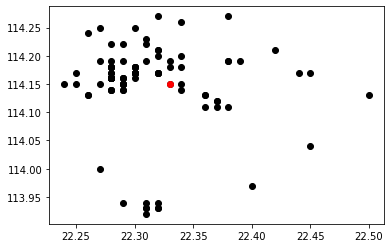

In [281]:
plt.scatter(x=dtf["x"], y=dtf["y"], color="black")
plt.scatter(x=start[0], y=start[1], color="red")
plt.show()

In [282]:
'''
Creates a map with folium.
:parameter
    :param dtf: pandas
    :param x: str - column with latitude
    :param y: str - column with longitude
    :param starting_point: list - coordinates (ex. [45.0703, 7.6869])
    :param tiles: str - "cartodbpositron", "OpenStreetMap", "Stamen Terrain", "Stamen Toner"
    :param popup: str - column with text to popup if clicked, if None there is no popup
    :param size: str - column with size variable, if None takes size=5
    :param color: str - column with color variable, if None takes default color
    :param lst_colors: list - list with multiple colors to use if color column is not None, if not given it generates randomly
    :param marker: str - column with marker variable, takes up to 7 unique values
:return
    map object to display
'''
def plot_map(dtf, x, y, start, zoom=12, tiles="cartodbpositron", popup=None, size=None, color=None, legend=False, lst_colors=None, marker=None):
    data = dtf.copy()

    ## create columns for plotting
    if color is not None:
        lst_elements = sorted(list(dtf[color].unique()))
        lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in range(len(lst_elements))] if lst_colors is None else lst_colors
        data["color"] = data[color].apply(lambda x: lst_colors[lst_elements.index(x)])

    if size is not None:
        scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
        data["size"] = scaler.fit_transform(data[size].values.reshape(-1,1)).reshape(-1)

    ## map
    map_ = folium.Map(location=start, tiles=tiles, zoom_start=zoom)

    if (size is not None) and (color is None): 
        data.apply(lambda row: folium.CircleMarker(location=[row[x],row[y]], popup=row[popup],
                                                   color='#3186cc', fill=True, radius=row["size"]).add_to(map_), axis=1)
    elif (size is None) and (color is not None):
        data.apply(lambda row: folium.CircleMarker(location=[row[x],row[y]], popup=row[popup],
                                                   color=row["color"], fill=True, radius=5).add_to(map_), axis=1)
    elif (size is not None) and (color is not None):
        data.apply(lambda row: folium.CircleMarker(location=[row[x],row[y]], popup=row[popup],
                                                   color=row["color"], fill=True, radius=row["size"]).add_to(map_), axis=1)
    else:
        data.apply(lambda row: folium.CircleMarker(location=[row[x],row[y]], popup=row[popup],
                                                   color='#3186cc', fill=True, radius=5).add_to(map_), axis=1)
    
    ## tiles
    layers = ["cartodbpositron", "openstreetmap", "Stamen Terrain", 
              "Stamen Water Color", "Stamen Toner", "cartodbdark_matter"]
    for tile in layers:
        folium.TileLayer(tile).add_to(map_)
    folium.LayerControl().add_to(map_)
    
    ## legend
    if (color is not None) and (legend is True):
        legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
        for i in lst_elements:
            legend_html = legend_html+"""&nbsp;<i class="fa fa-circle fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+""""></i>&nbsp;"""+str(i)+"""<br>"""
        legend_html = legend_html+"""</div>"""
        map_.get_root().html.add_child(folium.Element(legend_html))
    
    ## add marker
    if marker is not None:
        lst_elements = sorted(list(dtf[marker].unique()))
        lst_colors = ["black","red","blue","green","pink","orange","gray"]  #7
        ### too many values, can't mark
        if len(lst_elements) > len(lst_colors):
            raise Exception("marker has uniques > "+str(len(lst_colors)))
        ### binary case (1/0): mark only 1s
        elif len(lst_elements) == 2:
            data[data[marker]==lst_elements[1]].apply(lambda row: folium.Marker(location=[row[x],row[y]], popup=row[marker], draggable=False, 
                                                                                icon=folium.Icon(color=lst_colors[0])).add_to(map_), axis=1) 
        ### normal case: mark all values
        else:
            for i in lst_elements:
                data[data[marker]==i].apply(lambda row: folium.Marker(location=[row[x],row[y]], popup=row[marker], draggable=False, 
                                                                      icon=folium.Icon(color=lst_colors[lst_elements.index(i)])).add_to(map_), axis=1)
    return map_

In [309]:
map_ = plot_map(dtf, x="x", y="y", start=start, zoom=12, 
                tiles="cartodbpositron", popup="id", 
                color="pos", lst_colors=["red","black"])
map_

In [322]:
for i in range(len(dtf)):
    points = [start, dtf[["x","y"]].iloc[i].tolist()]
    folium.PolyLine(points, color="red", weight=0.5, opacity=0.5).add_to(map_)
map_

### 1 - Shortest Path

###### Time

In [286]:
start = dtf[dtf["id"]==0][["x","y"]].values[0]
start

array([ 22.33, 114.15])

In [287]:
end = dtf[dtf["id"]==68][["x","y"]].values[0]
end

array([ 22.34, 114.15])

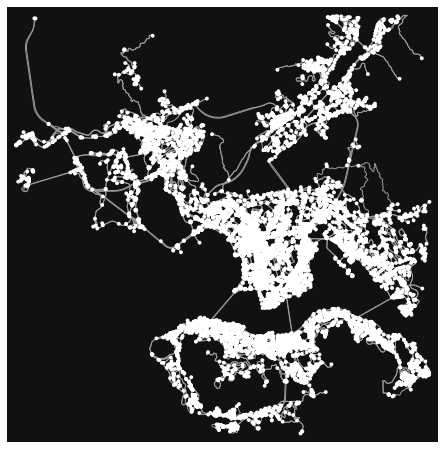

In [317]:
mode = 'drive'        #'drive', 'bike', 'walk'
optimizer = 'length'  #'length','time'

G = ox.graph_from_point(start, dist=10000, network_type=mode)
ox.plot_graph(G)
plt.show()

In [318]:
#G = ox.utils_graph.get_largest_component(G, strongly=True)
#ox.plot_graph(G)
#plt.show()

In [319]:
# find the nearest node to the start/end location
start_node = ox.distance.nearest_nodes(G, start[1], start[0])
end_node = ox.distance.nearest_nodes(G, end[1], end[0])

print("start:", start_node, "|", "end:", end_node)

start: 493883072 | end: 480679404


In [320]:
shortest_route = nx.shortest_path(G, start_node, end_node, weight=optimizer, method='dijkstra')
shortest_route

[493883072,
 289293755,
 289294146,
 289295423,
 289295628,
 289295766,
 289295767,
 289295566,
 5101376323,
 4844635141,
 289295620,
 274244744,
 1641766635,
 1641766639,
 1641766654,
 999331442,
 1191992696,
 480679312,
 999331647,
 1641766800,
 480679404]

In [327]:
map_ = plot_map(dtf, x="x", y="y", start=start, zoom=12, 
                tiles="cartodbpositron", popup="id", 
                color="pos", lst_colors=["red","black"])

ox.plot_route_folium(G, route=shortest_route, route_map=map_, color="red", weight=1)
map_

###### Length

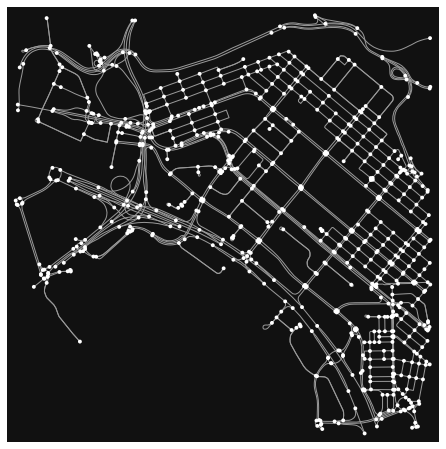

In [240]:
CENTER_LOCATION = start
DIST = 1500
NUM_VEHICLES = 4

G = ox.graph_from_point(CENTER_LOCATION, dist=DIST, network_type='drive')
*_, = ox.plot_graph(G)

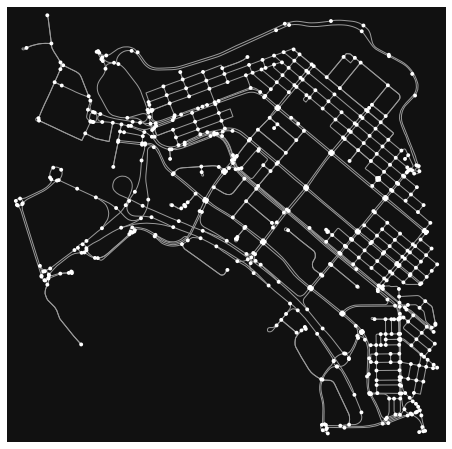

In [241]:
G = ox.utils_graph.get_largest_component(G, strongly=True)
*_, = ox.plot_graph(G)

In [242]:
depot = ox.distance.nearest_nodes(G, CENTER_LOCATION[1], CENTER_LOCATION[0])
depot

493883072

In [244]:
from operator import itemgetter

bus_stops = ox.geometries_from_point(CENTER_LOCATION, {"highway": "bus_stop"}, dist=DIST)

# Get the nearest nodes to bus stops
bus_stop_nodes = list(map(itemgetter(1), bus_stops.index.values))
bus_stop_nodes[:5]

/Users/mdp/opt/anaconda3/envs/py38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[288997862, 480680818, 506479191, 571171049, 571171690]

In [246]:
nodes = [depot] + bus_stop_nodes

In [252]:
import geopy.distance

for index, bus_stop in bus_stops.iterrows():
    nearest_node = ox.distance.nearest_nodes(G, bus_stop.geometry.x, bus_stop.geometry.y)
    distance = geopy.distance.distance((G.nodes[nearest_node]['y'], G.nodes[nearest_node]['x']), (bus_stop.geometry.y, bus_stop.geometry.x))

    # Add bus stop node
    G.add_node(index[1], x=bus_stop.geometry.x, y=bus_stop.geometry.y)
    
    # Add bidirectional edge
    G.add_edge(index[1], nearest_node, weight=distance.m)
    G.add_edge(nearest_node, index[1], weight=distance.m)

# Get edges as GeoDataFrames
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
edges.head()

/Users/mdp/opt/anaconda3/envs/py38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


osmid oneway lanes   
u         v          key                                                   
50060656  574307497  0     [283910385, 99713770, 795937018]   True     2  \
274243013 274243016  0    [1133373520, 909703708, 30151798]   True     3   
274243016 4773779436 0     [30150256, 909700420, 102368462]   True     2   
          6984393965 0                           1133373517   True     2   
274244648 999331464  0                             86113203   True     2   

                                                                       name   
u         v          key                                                      
50060656  574307497  0                                      大埔道 Tai Po Road  \
274243013 274243016  0                          西九龍走廊 West Kowloon Corridor   
274243016 4773779436 0    [西九龍走廊 West Kowloon Corridor, 通州街 Tung Chau St...   
          6984393965 0                          西九龍走廊 West Kowloon Corridor   
274244648 999331464  0                                荔枝角道 Lai Chi Kok Road   

                             highway maxspeed reversed   length   
u         v          key                                          
50060656  574307497  0       primary       50    False  286.650  \
274243013 274243016  0         trunk       70    False  433.182   
274243016 4773779436 0    trunk_link      NaN    False  235.161   
          6984393965 0         trunk       70    False  264.169   
274244648 999331464  0      tertiary      NaN    False   48.374   

                                                                   geometry   
u         v          key                                                      
50060656  574307497  0    LINESTRING (114.15948 22.34263, 114.15957 22.3...  \
274243013 274243016  0    LINESTRING (114.15900 22.32729, 114.16014 22.3...   
274243016 4773779436 0    LINESTRING (114.16231 22.32489, 114.16271 22.3...   
          6984393965 0    LINESTRING (114.16231 22.32489, 114.16238 22.3...   
274244648 999331464  0    LINESTRING (114.14886 22.33591, 114.14925 22.3...   

                           bridge  ref  weight junction tunnel access  
u         v          key                                               
50060656  574307497  0        NaN  NaN     NaN      NaN    NaN    NaN  
274243013 274243016  0    viaduct    5     NaN      NaN    NaN    NaN  
274243016 4773779436 0        yes  NaN     NaN      NaN    NaN    NaN  
          6984393965 0    viaduct    5     NaN      NaN    NaN    NaN  
274244648 999331464  0        NaN  NaN     NaN      NaN    NaN    NaN

<Figure size 432x288 with 0 Axes>

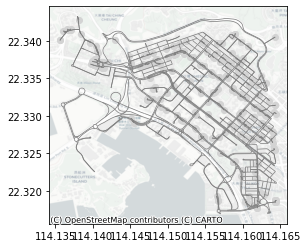

In [256]:
# Create a new figure object
ax = plt.figure()

# Plot the highway graph
ax = edges.plot(linewidth=0.75, color='gray')

# Plot the bus stops
ax = bus_stops.plot(ax=ax, facecolor='lightgray')

# Turn off offsetting of tick labels
ax.ticklabel_format(useOffset=False)

# Add a basemap to the figure object
import contextily as ctx
ctx.add_basemap(ax, crs=edges.crs, source=ctx.providers.CartoDB.Positron)

In [258]:
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2


# Create the routing index manager
manager = pywrapcp.RoutingIndexManager(len(nodes), NUM_VEHICLES, nodes.index(depot))
# Create routing model
routing = pywrapcp.RoutingModel(manager)

In [259]:
# Define distance callback
def distance_callback(from_node_index, to_node_index):
    from_node = nodes[manager.IndexToNode(from_node_index)]
    to_node = nodes[manager.IndexToNode(to_node_index)]
    return nx.shortest_path_length(G, from_node, to_node)

# Register distance callback
transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

In [260]:
# Add Distance constraint.
dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    3000,  # vehicle maximum travel distance
    True,  # start cumul to zero
    dimension_name
)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

In [261]:
# Set path-cheapest-arc search strategy
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

# Solve the problem
solution = routing.SolveWithParameters(search_parameters)

In [262]:
# Print the solution
total_distance = 0
for vehicle_id in range(NUM_VEHICLES):
    index = routing.Start(vehicle_id)
    route_distance = 0
    route = []
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route.append(node_index)
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
    route.append(manager.IndexToNode(index))
    print(f"Route for vehicle {vehicle_id}:\n{' -> '.join(str(node) for node in route)}")
    print(f"Distance of route: {route_distance}m\n")
    total_distance += route_distance
print(f"Total distance of all routes: {total_distance}m")

Route for vehicle 0:
0 -> 0
Distance of route: 0m

Route for vehicle 1:
0 -> 18 -> 313 -> 25 -> 284 -> 66 -> 29 -> 67 -> 28 -> 26 -> 158 -> 27 -> 88 -> 1 -> 229 -> 23 -> 233 -> 24 -> 253 -> 137 -> 205 -> 161 -> 19 -> 260 -> 74 -> 267 -> 69 -> 243 -> 68 -> 139 -> 221 -> 140 -> 9 -> 138 -> 0
Distance of route: 0m

Route for vehicle 2:
0 -> 0
Distance of route: 0m

Route for vehicle 3:
0 -> 141 -> 143 -> 150 -> 86 -> 142 -> 124 -> 147 -> 308 -> 204 -> 125 -> 148 -> 309 -> 145 -> 310 -> 146 -> 126 -> 132 -> 127 -> 311 -> 256 -> 144 -> 225 -> 155 -> 268 -> 156 -> 122 -> 13 -> 264 -> 136 -> 271 -> 312 -> 116 -> 154 -> 296 -> 261 -> 295 -> 134 -> 269 -> 300 -> 270 -> 301 -> 115 -> 302 -> 117 -> 133 -> 262 -> 288 -> 46 -> 135 -> 47 -> 173 -> 114 -> 247 -> 263 -> 248 -> 2 -> 232 -> 294 -> 87 -> 292 -> 165 -> 293 -> 179 -> 41 -> 222 -> 42 -> 178 -> 43 -> 187 -> 170 -> 227 -> 184 -> 234 -> 172 -> 188 -> 177 -> 240 -> 250 -> 251 -> 214 -> 239 -> 215 -> 160 -> 213 -> 162 -> 20 -> 283 -> 128 -> 181 

In [263]:
# Create map object
m = folium.Map(location=CENTER_LOCATION, zoom_start=16)

# Plot depot
depot_coords = (G.nodes[depot]['y'], G.nodes[depot]['x'])
folium.Marker(location=depot_coords, icon=folium.Icon(color='red', icon='home', prefix='fa'), tooltip=f"Depot {depot_coords}").add_to(m)

# Plot bus stops
for index, bus_stop in bus_stops.iterrows():
    stop_coords = (bus_stop.geometry.y, bus_stop.geometry.x)
    folium.Marker(location=stop_coords, icon=folium.Icon(color='green', icon='bus', prefix='fa'), tooltip=f"Bus Stop {stop_coords}").add_to(m)

# Create colors for routes
colors = ['blue', 'orange', 'purple', 'green']

# Plot routes
for vehicle_id in range(NUM_VEHICLES):
    index = routing.Start(vehicle_id)
    route = []
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route.append(nodes[node_index])
        index = solution.Value(routing.NextVar(index))
    route.append(nodes[manager.IndexToNode(index)])
    color = colors[vehicle_id % NUM_VEHICLES]
    # Create a list of line segments for the route
    segments = []
    for i in range(len(route)-1):
        # Get shortest path between nodes
        path = nx.shortest_path(G, route[i], route[i + 1], weight='length')
        # Add line segment to list
        segments.append([(G.nodes[node]['y'], G.nodes[node]['x']) for node in path])
    # Create polyline from line segments and add to map
    for segment in segments:
        folium.PolyLine(locations=segment, color=color, weight=5).add_to(m)

# Display map
m

KeyboardInterrupt: 

In [285]:
end = dtf[dtf["id"]==68][["x","y"]].values[0]
end

array([ 22.34, 114.15])

In [ ]:
G = ox.graph_from_point(start, dist=2000, network_type='drive')
*_, = ox.plot_graph(G)
